In [1]:
import warnings
warnings.filterwarnings("ignore")

import torchaudio as ta
ta.set_audio_backend("sox_io")
import torch
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torch.autograd.profiler as profiler
import pytorch_lightning as pl

import numpy as np
import os

import IPython.display as ipd

import numpy as np

import math

import glob

from tqdm.auto import tqdm

from python_files.Noise_Reduction_Datagen_fp16 import Signal_Synthesis_DataGen
from python_files.unet_basic import Model

import warnings

warnings.filterwarnings("ignore")

import gc

# from numba import jit

In [2]:
from fastai.text.all import *
from fastai.data.core import DataLoaders

In [3]:
torch.backends.cudnn.benchmark = True

In [4]:
torch.__version__

'1.8.0dev'

In [5]:
torch.cuda.is_available()

True

In [6]:
torch.set_default_dtype(torch.float16)
torch.set_default_tensor_type(torch.FloatTensor)

In [7]:
# test_model = Model()

# test_model(torch.rand(1, 1, 16384*10)).shape

In [8]:
torch.rand(32, 16384*10).unsqueeze(dim=1).shape

torch.Size([32, 1, 163840])

In [9]:
noise_dir = "./dataset/UrbanSound8K-Resampled/"
signal_dir = "./dataset/cv-corpus-5.1-2020-06-22-Resampled/en/clips/"
signal_nums_save = "./dataset_loader_files/signal_paths_nums_save.npy"
num_noise_samples=1000
num_signal_samples = 1000
noise_save_path = ""#"./dataset_loader_files/noise_paths_resampled_save.npy"
train = True
n_fft=1024
win_length=n_fft
hop_len=n_fft//4
create_specgram = False
perform_stft = False
default_sr = 16000
sec = (16384/default_sr)*4
augment=True
device_datagen = "cpu"

train_ds = Signal_Synthesis_DataGen(noise_dir, signal_dir, \
                signal_nums_save=signal_nums_save, num_noise_samples=num_noise_samples, \
                num_signal_samples=num_signal_samples, noise_path_save=noise_save_path, \
                 n_fft=n_fft, win_length=win_length, hop_len=hop_len, create_specgram=create_specgram, \
                 perform_stft=perform_stft, normalize=True, default_sr=default_sr, sec=sec, epsilon=1e-5, augment=False, device=device_datagen)

Loading nums from npy file
1000


In [10]:
train = False
num_signal_samples = 100
num_noise_samples=100
val_ds = Signal_Synthesis_DataGen(noise_dir, signal_dir, \
                signal_nums_save=signal_nums_save, num_noise_samples=num_noise_samples, \
                num_signal_samples=num_signal_samples, noise_path_save=noise_save_path, train=train, \
                 n_fft=n_fft, win_length=win_length, hop_len=hop_len, create_specgram=create_specgram, \
                 perform_stft=perform_stft, normalize=True, default_sr=default_sr, sec=sec, epsilon=1e-5, augment=False, device=device_datagen)

Loading nums from npy file
100


In [14]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

BATCH_SIZE = 22
shuffle = True
num_workers = 7
pin_memory = True

# data_loader = DataLoader(signal_synthesis_dataset, batch_size=BATCH_SIZE, shuffle=shuffle, num_workers=num_workers)
# data_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=shuffle, num_workers=num_workers, pin_memory=pin_memory)

dls = DataLoaders.from_dsets(train_ds, val_ds, bs=BATCH_SIZE, num_workers=num_workers, pin_memory=pin_memory).to(device)

In [15]:
for data in dls.train:
    print(data[0].shape)

torch.Size([22, 1, 65536])
torch.Size([22, 1, 65536])
torch.Size([22, 1, 65536])
torch.Size([22, 1, 65536])
torch.Size([22, 1, 65536])
torch.Size([22, 1, 65536])
torch.Size([22, 1, 65536])
torch.Size([22, 1, 65536])
torch.Size([22, 1, 65536])
torch.Size([22, 1, 65536])
torch.Size([22, 1, 65536])
torch.Size([22, 1, 65536])
torch.Size([22, 1, 65536])
torch.Size([22, 1, 65536])


KeyboardInterrupt: 

In [16]:
65536/16000

4.096

In [12]:
train_ds.__len__()

100000

In [13]:
# %%time
# # data_loader_iter = iter(data_loader)
# for index, i in enumerate(data_loader):
# #     i = next(data_loader)
#     if index < 32-1:
#         pass
#     else:
#         break
#     print(i[1].shape,i[0].min(), i[0].max(), i[0].dtype, index)

In [14]:
# %%time
# stft_sig = torch.stft(i[0], n_fft=n_fft, hop_length=hop_len, win_length=win_length)
# istft_sig = torch.istft(stft_sig, n_fft=n_fft, hop_length=hop_len, win_length=win_length)
# i[1].max()

# nan_sig = signal_synthesis_dataset.__getitem__(119)

In [15]:
# nan_sig[0].max(), nan_sig[1].min()

In [16]:
# stft_sig.max()

In [17]:
# stft_sig.shape

In [18]:
# istft_sig.shape

In [19]:
# def normalize(tensor):
#     tensor_minusmean = tensor - tensor.min()
#     return tensor_minusmean/tensor_minusmean.abs().max()

In [20]:
# aud = i[0][0]

# aud.dtype

# aud.max(), aud.min()

In [21]:
# x = aud.t().to("cpu").numpy()
# ipd.Audio(x, rate=default_sr)

In [22]:
# sig1 = i[0].unsqueeze(dim=1)
# sig2 = i[0].unsqueeze(dim=1)
# stacked_sig = torch.cat((sig1, sig2), dim=1)

# sig2 = i[0].unsqueeze(dim=1)
# sig2.shape

# torch.sum(stacked_sig, dim=1).shape

In [23]:
# np.floor(((default_sr*sec) - (win_length - 1) - 1)/ hop_len + 5)

In [24]:
# n_fft // 2 + 1

# n_fft // 2 + 1

In [25]:
# stft_sig.shape

In [13]:
class Negative_SNR_Loss(nn.Module):
    def __init__(self):
        super(Negative_SNR_Loss, self).__init__()
    
    def forward(self, sig_pred, sig_true):
        
        sig_true_sq = torch.square(sig_true)
        sig_pred_sq = torch.square(sig_true - sig_pred)

        sig_true_mean = torch.mean(sig_true_sq)
        sig_pred_mean = torch.mean(sig_pred_sq)

        snr = sig_true_mean / sig_pred_mean + 1e-7
        loss = -1*torch.log10(snr)

        return loss

In [14]:
class Mod_MSELoss(nn.Module):
    def __init__(self, mul_factor):
        super(Mod_MSELoss, self).__init__()
        self.loss_fn = nn.MSELoss(reduction="mean")
        self.mul_factor = mul_factor
        
        
    def forward(self, sig_pred, sig_true):
        loss = self.loss_fn(sig_pred, sig_true)
        loss = self.mul_factor*loss
        return loss

In [28]:
# class InstantLayerNormalization(nn.Module):
#     def __init__(self, in_shape, out_shape):
#         self.in_shape = in_shape
#         self.out_shape = out_shape
        
#         self.epsilon = 1e-7
#         self.gamma = None
#         self.beta = None
        
#         super(InstantLayerNormalization, self).__init__()
        
#         self.gamma = torch.ones(out_shape)
#         self.gamma = nn.Parameter(self.gamma)
        
#         self.beta = torch.zeros(out_shape)
#         self.beta = nn.Parameter(self.beta)
        
#     def forward(self, inps):
#         mean = inps.mean(-1, keepdim=True)
#         variance = torch.mean(torch.square(inps - mean), dim=-1, keepdim=True)
#         std = torch.sqrt(variance + self.epsilon)
        
#         outs = (inps - mean) / std
#         print(outs.shape, self.gamma.shape)
#         outs = outs * self.gamma
#         outs = outs + self.beta
        
#         return outs
    
# class Multiply():
#     def __init__(self):
#         super(Multiply, self).__init__()
    
#     def forward(self, ten1, ten2):
#         mul_out = torch.mul(ten1, ten2)
#         return mul_out

# class NoiseReducer(pl.LightningModule):
#     def __init__(self, default_sr, n_fft, win_length, hop_len, sec, dropout=0.5, batch_first=True, stride=2, normalized=False, bidir=False):
        
#         self.default_sr = default_sr
#         self.n_fft = n_fft
#         self.win_length = win_length
#         self.hop_len = hop_len
#         self.sec = sec
#         self.normalized = normalized
        
#         self.conv_filters = 512
        
#         # Universal LSTM Units
#         self.batch_first = True
#         self.dropout = 0.25
#         self.bidir = bidir
#         self.lstm_prelu_ins = int(np.floor(((default_sr*sec) - (win_length - 1) - 1)/ hop_len + 5))
        
#         # LSTM 1 UNITS
#         self.rnn1_dims = n_fft // 2 + 1
#         self.hidden_size_1 = 256
#         self.num_layers = 2
       
        
#         # LSTM 2 UNITS
#         self.rnn2_dims = self.conv_filters
#         self.hidden_size_2 = self.hidden_size_1
        
#         # Conv1d Layer Units
#         self.conv1_in = 1
#         self.conv1_out = self.conv_filters
        
        
        
#         # InstanceNorm Layer Units
#         self.instance1_in = self.rnn1_dims
#         self.instance2_in = self.conv1_out
        
#         # Dense1 Layer Units
#         self.dense1_in = self.hidden_size_1
#         self.dense1_out = self.rnn1_dims #int(np.floor(((default_sr*sec) - (win_length - 1) - 1)/ hop_len + 5))#3))
        
#         # Dense2 Layer Units
#         self.dense2_in = self.hidden_size_2
#         self.dense2_out = self.conv1_out
        
#         # Dense3 Layer Units
#         self.dense3_in = self.hidden_size_1
#         self.dense3_out = self.rnn1_dims
        
#         # Conv2d Layer Units
#         self.conv2_in = self.dense2_out
#         self.conv2_out = self.conv_filters
        

#         super(NoiseReducer, self).__init__()
        
#         self.loss_fn = Mod_MSELoss(mul_factor=1000)
        
#         self.lstm1 = nn.LSTM(input_size=self.rnn1_dims, hidden_size=self.hidden_size_1, num_layers=self.num_layers, batch_first=self.batch_first, dropout=self.dropout, bidirectional=self.bidir)
#         self.lstm3 = nn.LSTM(input_size=self.rnn1_dims, hidden_size=self.hidden_size_1, num_layers=self.num_layers, batch_first=self.batch_first, dropout=self.dropout, bidirectional=self.bidir)
# #         self.lstm1_1 = nn.LSTMCell(input_size=self.rnn1_dims, hidden_size==self.hidden_size_1, )
        
#         print(self.rnn2_dims)
#         self.lstm2 = nn.LSTM(input_size=self.rnn2_dims, hidden_size=self.hidden_size_2, num_layers=self.num_layers*2, batch_first=self.batch_first, dropout=self.dropout, bidirectional=self.bidir)
        
        
#         self.instancenorm1 = nn.InstanceNorm1d(self.rnn1_dims)
#         self.instancenorm2 = nn.InstanceNorm1d(self.rnn2_dims)
#         self.instancenorm3 = nn.InstanceNorm1d(self.rnn1_dims)
        
#         self.dense1 = nn.Linear(self.dense1_in, self.dense1_out)
#         self.dense2 = nn.Linear(self.dense2_in, self.dense2_out)
#         self.dense3 = nn.Linear(self.dense3_in, self.dense3_out)
        
#         self.conv1 = nn.Conv1d(self.conv1_in, self.conv1_out, kernel_size=3, stride=1, padding=1)
#         self.conv2 = nn.Conv1d(self.conv2_in, self.conv2_out, kernel_size=3, stride=1, padding=1)
        
#         self.prelu_conv1 = nn.PReLU(self.conv1_out)
#         self.prelu_conv2 = nn.PReLU(self.conv2_out)
        
#         self.prelu_lstm1 = nn.PReLU(self.lstm_prelu_ins)
#         self.prelu_lstm3 = nn.PReLU(self.lstm_prelu_ins)
#         self.prelu_lstm2 = nn.PReLU(self.hidden_size_2)
        
#     @torch.jit.export
#     def stft_layer(self, sig):
        
#         sig_stft = torch.stft(sig, n_fft=self.n_fft, hop_length=self.hop_len, win_length=self.win_length)
        
#         sig_cplx = torch.view_as_complex(sig_stft)
#         mag = sig_cplx.abs().permute(0, 2, 1)
#         angle = sig_cplx.angle().permute(0, 2, 1)

# #         mag = sig_stft[:,:,:,0].permute(0, 2, 1)
# #         angle = sig_stft[:,:,:,1].permute(0, 2, 1)
        
#         return [mag, angle]
    
#     @torch.jit.export
#     def istft_layer(self, mag, angle):
#         mag = mag.permute(0, 2, 1)
#         angle = angle.permute(0, 2, 1)
#         mag = torch.unsqueeze(mag, dim=-1)
#         angle = torch.unsqueeze(angle, dim=-1)
#         pre_stft = torch.cat((mag, angle), dim=-1)
#         stft_sig = torch.istft(pre_stft, n_fft=self.n_fft, win_length=self.win_length, hop_length=self.hop_len)
        
#         return stft_sig
    
#     @torch.cuda.amp.autocast()
#     def forward(self, inp_tensor):
        
#         mag, angle = self.stft_layer(inp_tensor)
#         mag_norm = self.instancenorm1(mag)
#         angle_norm = self.instancenorm3(angle)
        
#         x_mag, hidden_states_mag = self.lstm1(mag_norm)
#         x_angle, hidden_states_angle = self.lstm3(angle_norm)

#         mask_mag = F.relu(self.dense1(x_mag))
#         estimated_mag = torch.mul(mag, mask_mag)
        
#         mask_angle = F.relu(self.dense3(x_angle))
#         estimated_angle = torch.mul(angle, mask_angle)
        
#         signal = self.istft_layer(estimated_mag, estimated_angle)
#         signal = signal.unsqueeze(dim=1)

#         feature_rep = self.conv1(signal)
#         feature_rep = self.prelu_conv2(feature_rep)
        
#         feature_norm = self.instancenorm2(feature_rep)
#         feature_norm = feature_norm.permute(0, 2, 1)
#         x, hidden_states = self.lstm2(feature_norm)
#         mask = self.dense2(x)
#         feature_mask = F.relu(mask)
#         feature_mask = feature_mask.permute(0, 2, 1)

#         estimate_feat = torch.mul(feature_rep, feature_mask)
        
#         estimate_frames = (self.conv2(estimate_feat))
#         estimate_frames = self.prelu_conv2(estimate_frames)
#         estimate_sig = torch.sum(estimate_frames, dim=1)
        
#         return estimate_sig
    
#     def training_step(self, batch, batch_idx):
#         x, y = batch
#         y_pred = self(x.unsqueeze(dim=1).to(device))
#         loss = self.loss_fn(y_pred, y.unsqueeze(dim=1))

#         return loss
#     def validation_step(self, batch, batch_idx):
#         x, y = batch
#         y_pred = self(x.to(device))
        
#         loss = self.loss_fn(y_pred, y)
#         self.log("val_loss", loss, enable_graph=True, on_epoch=True, prog_bar=True)
    
#     def configure_optimizers(self):
#         return torch.optim.AdamW(self.parameters(), lr=0.001, weight_decay=5e-5)

In [15]:
class DownSamplingLayer(nn.Module):
    def __init__(self, channel_in, channel_out, dilation=1, kernel_size=15, stride=1, padding=7):
        super(DownSamplingLayer, self).__init__()
        self.main = nn.Sequential(
            nn.Conv1d(channel_in, channel_out, kernel_size=kernel_size,
                      stride=stride, padding=padding, dilation=dilation),
            nn.BatchNorm1d(channel_out),
            nn.LeakyReLU(negative_slope=0.1)
        )

    def forward(self, ipt):
        return self.main(ipt)

class UpSamplingLayer(nn.Module):
    def __init__(self, channel_in, channel_out, kernel_size=5, stride=1, padding=2):
        super(UpSamplingLayer, self).__init__()
        self.main = nn.Sequential(
            nn.Conv1d(channel_in, channel_out, kernel_size=kernel_size,
                      stride=stride, padding=padding),
            nn.BatchNorm1d(channel_out),
            nn.LeakyReLU(negative_slope=0.1, inplace=True),
        )

    def forward(self, ipt):
        return self.main(ipt)

class Model(pl.LightningModule):
    def __init__(self, n_layers=12, channels_interval=24):
        super(Model, self).__init__()
        self.loss_fn = Mod_MSELoss(mul_factor=1000)
        self.n_layers = n_layers
        self.channels_interval = channels_interval
        encoder_in_channels_list = [1] + [i * self.channels_interval for i in range(1, self.n_layers)]
        encoder_out_channels_list = [i * self.channels_interval for i in range(1, self.n_layers + 1)]

        #          1    => 2    => 3    => 4    => 5    => 6   => 7   => 8   => 9  => 10 => 11 =>12
        # 16384 => 8192 => 4096 => 2048 => 1024 => 512 => 256 => 128 => 64 => 32 => 16 =>  8 => 4
        self.encoder = nn.ModuleList()
        for i in range(self.n_layers):
            self.encoder.append(
                DownSamplingLayer(
                    channel_in=encoder_in_channels_list[i],
                    channel_out=encoder_out_channels_list[i]
                )
            )

        self.middle = nn.Sequential(
            nn.Conv1d(self.n_layers * self.channels_interval, self.n_layers * self.channels_interval, 15, stride=1,
                      padding=7),
            nn.BatchNorm1d(self.n_layers * self.channels_interval),
            nn.LeakyReLU(negative_slope=0.1, inplace=True)
        )

        decoder_in_channels_list = [(2 * i + 1) * self.channels_interval for i in range(1, self.n_layers)] + [
            2 * self.n_layers * self.channels_interval]
        decoder_in_channels_list = decoder_in_channels_list[::-1]
        decoder_out_channels_list = encoder_out_channels_list[::-1]
        self.decoder = nn.ModuleList()
        for i in range(self.n_layers):
            self.decoder.append(
                UpSamplingLayer(
                    channel_in=decoder_in_channels_list[i],
                    channel_out=decoder_out_channels_list[i]
                )
            )

        self.out = nn.Sequential(
            nn.Conv1d(1 + self.channels_interval, 1, kernel_size=1, stride=1),
            nn.Tanh()
        )

    def forward(self, input):
        tmp = []
        o = input

        # Up Sampling
        for i in range(self.n_layers):
            o = self.encoder[i](o)
#             print(o.shape)
            tmp.append(o)
            # [batch_size, T // 2, channels]
            o = o[:, :, ::2]

        o = self.middle(o)

        # Down Sampling
        for i in range(self.n_layers):
            # [batch_size, T * 2, channels]
            o = F.interpolate(o, scale_factor=2, mode="linear", align_corners=True)
            # Skip Connection
            # print(o.shape, len(tmp))
            o = torch.cat([o, tmp[self.n_layers - i -1]], dim=1)
            o = self.decoder[i](o)

        o = torch.cat([o, input], dim=1)
        o = self.out(o)
        return o

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_pred = self(x.unsqueeze(dim=1).to(device))
        loss = self.loss_fn(y_pred, y.unsqueeze(dim=1))

        return loss
    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_pred = self(x.unsqueeze(dim=1).to(device))
        
        loss = self.loss_fn(y_pred, y.unsqueeze(dim=1))
        self.log("val_loss", loss, enable_graph=True, on_epoch=True, prog_bar=True)
    
    def configure_optimizers(self):
        return torch.optim.AdamW(self.parameters(), lr=0.001, weight_decay=5e-5)

In [16]:
use_scripted_model = False
w_decay = 1e-4

if not use_scripted_model:
    print("Using Primary model")
    model = Model()#NoiseReducer(default_sr=default_sr, n_fft=n_fft, win_length=win_length, hop_len=hop_len, sec=sec).to(device)
    model.to(device)
else:
    print("Using Scripted Model")
    model = scripted_model

optimizer = torch.optim.AdamW(model.parameters(), lr=0.0001, weight_decay=0)
criterion = Mod_MSELoss(mul_factor=1000)
n_epochs=100


model.train()
scaler = torch.cuda.amp.GradScaler()

Using Primary model


In [17]:
learn = Learner(dls, model, loss_func=criterion, model_dir="./Model_saves/", \
                cbs=[ShowGraphCallback(), SaveModelCallback(monitor='valid_loss', fname='bestmodel', every_epoch=True)]).to_fp16()

In [20]:
learn.load("learner_cnn_save")

SuggestedLRs(lr_min=0.33113112449646, lr_steep=0.0008317637839354575)

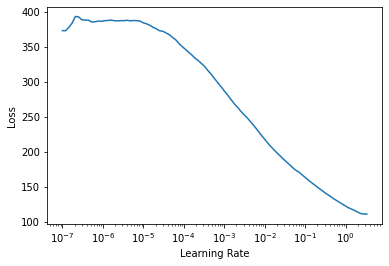

In [32]:
learn.lr_find()

In [21]:
learn.lr = 0.33113112449646

In [22]:
learn.fit_one_cycle(20)

IndexError: list index out of range

In [37]:
learn.save("learner_cnn_save")

Path('Model_saves/learner_cnn_save.pth')

In [33]:
# checkpoint = pl.callbacks.ModelCheckpoint(dirpath="Model_saves/", monitor="val_loss", mode="min", verbose=True, filename="lightnng_save_lstm.pt")

# trainer = pl.Trainer(gpus=[0],max_epochs=20, \
#                     precision=16, \
#                     amp_backend="native",\
#                     num_sanity_val_steps=10, \
#                     benchmark=True, reload_dataloaders_every_epoch=True, \
#                     weights_save_path="./Model_saves/", weights_summary="top", \
#                     profiler="simple",  callbacks=[checkpoint])


# lr_finder = trainer.tuner.lr_find(model, dls.train, dls.valid)

# fig = lr_finder.plot(suggest=True); fig.show()

# lr_finder.suggestion()

# trainer.fit(model, dls.train, dls.valid)

In [34]:
/./././

SyntaxError: invalid syntax (<ipython-input-34-78632623dd44>, line 1)

In [ ]:
# fake_inputs = torch.randn(BATCH_SIZE, int(default_sr*sec)).type(torch.float32).to(device)
# outs = model(fake_inputs)
# outs.shape

In [ ]:
model.load_state_dict(torch.load("./Model_saves/Pytorch_model_2_save_LSTM_512_filters.pt"))

In [ ]:
scaler = torch.cuda.amp.GradScaler()

for epoch in range(1, n_epochs+1):
    
    loop = tqdm(enumerate(data_loader), leave=True, total=len(data_loader))
    train_loss = np.zeros((len(data_loader)))
    loop.set_description(f"Epoch: [ {epoch}/{n_epochs} ]\t")

    
    for index, (data, target) in loop:
        
        data = data.to(device)
        target = target.to(device)

        optimizer.zero_grad(set_to_none=True)
        
        with torch.cuda.amp.autocast():
            output = model(data)
            loss = criterion(output, target)
            
        scaler.scale(loss).backward()
        for group in optimizer.param_groups:
            for param in group["params"]:
                param.data = param.data.add(-w_decay * group["lr"], param.data)
        scaler.step(optimizer)
        scaler.update()
        
#         output = model(data)
#         loss = criterion(output, target)
        
#         loss.backward()
#         for group in optimizer.param_groups:
#             for param in group["params"]:
#                 param.data = param.data.add(-w_decay * group["lr"], param.data)
#         optimizer.step()

        train_loss[index] = loss.item()
        if np.isnan(loss.item()) or np.isnan(np.sum(train_loss)/index+1e-5):
            print(f"Data shape = {data.shape}\nTarget Shape = {target.shape}, \nindex = {index}")
        disp_loss = np.sum(train_loss)/index+1e-5
        loop.set_postfix(loss = disp_loss)

In [ ]:
param

In [ ]:
optimizer.closure()

In [ ]:
torch.save(model.state_dict(), "./Model_saves/Pytorch_model_2_save_LSTM_512_filters.pt")

In [ ]:
noise_add_sig, main_sig = signal_synthesis_dataset.__getitem__(1000)
noise_add_sig = torch.unsqueeze(noise_add_sig, dim=0).to(device)
main_sig = torch.unsqueeze(main_sig, dim=0).to(device)

In [ ]:
%%time
with torch.no_grad():
    outs = model(noise_add_sig)

In [ ]:
sim_loss = torch.nn.CosineSimilarity()(main_sig, outs)

In [ ]:
(sim_loss)

In [ ]:
outs.shape

In [ ]:
x = outs[0].t().to("cpu").numpy()
ipd.Audio(x, rate=default_sr)

In [ ]:
x = noise_add_sig[0].t().to("cpu").numpy()
ipd.Audio(x, rate=default_sr)

In [ ]:
x = main_sig[0].t().to("cpu").numpy()
ipd.Audio(x, rate=default_sr)

In [ ]:
noise_add_sig.mean()